# Updating embeddings

This notebook shows how to add new points to an existing embedding, using MNIST as an example.

The basic idea is to use an anchor constraint to pin the existing embedding in place, then embed the new points.

In [1]:
import pymde

import torch

In [2]:
mnist = pymde.datasets.MNIST()

Apr 25 02:45:25 PM: Loading cached dataset.


We'll start by embedding half of the MNIST data, using the preserve neighbors function.

Apr 25 02:45:26 PM: Computing 15-nearest neighbors, with max_distance=None
Sun Apr 25 14:45:35 2021 Building RP forest with 19 trees
Sun Apr 25 14:45:36 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Apr 25 02:45:47 PM: Computing quadratic initialization.
Apr 25 02:45:49 PM: Fitting a standardized embedding into R^2, for a graph with 35000 items and 576842 edges.
Apr 25 02:45:49 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Apr 25 02:45:49 PM: iteration 000 | distortion 0.208165 | residual norm 0.00546831 | step length 1 | percent change 0.00206683
Apr 25 02:45:50 PM: iteration 030 | distortion 0.157251 | residual norm 0.000336825 | step length 1 | percent change 1.14943
Apr 25 02:45:52 PM: iteration 060 | distortion 0.153908 | residual norm 0.000159439 | step length 1 | percent change 1.2087
Apr 25 02:45:53 PM: iteration 090 | distortion 0.153035 | residual norm 5.51977e-05 

<AxesSubplot:>

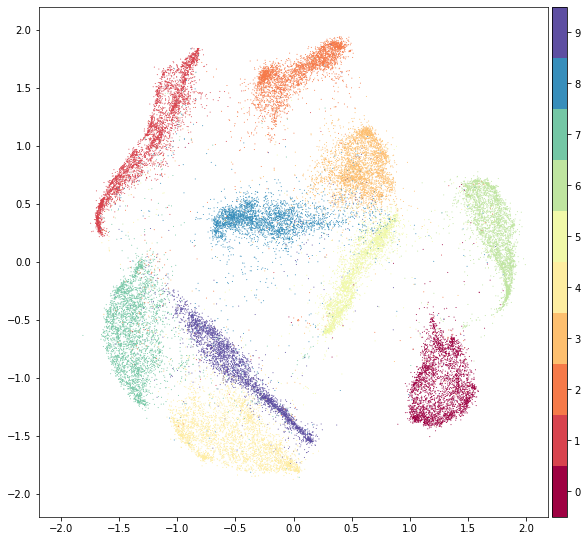

In [3]:
n_train = 35000
mnist_train = mnist.data[:n_train]
mnist_train_labels = mnist.attributes['digits'][:n_train]

mde = pymde.preserve_neighbors(mnist_train, constraint=pymde.Standardized(), verbose=True)
mde.embed(verbose=True)
mde.plot(color_by=mnist_train_labels)

## Updating the embedding

Next, we'll augment the above embedding with embedding vectors for the rest of the MNIST dataset.

We start by making an **anchor constraint**. This constraint says that we should pin the first `n_train` items to the embedding vectors that we just computed.

In [4]:
anchor_constraint = pymde.Anchored(
    anchors=torch.arange(n_train),
    values=mde.X,
)

We now make a new MDE problem, passing in the entire MNIST dataset to the `preserve_neighbors` function. Crucially,
we also provide the anchor constraint.

In [5]:
incremental_mde = pymde.preserve_neighbors(
    mnist.data,
    constraint=anchor_constraint,
    init='random',
    verbose=True)

Apr 25 02:46:01 PM: Computing 15-nearest neighbors, with max_distance=None
Sun Apr 25 14:46:01 2021 Building RP forest with 21 trees
Sun Apr 25 14:46:03 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations


The last step is to call the embed method. This will optimize the placement of the embedding vectors of the new images, while keeping the old ones fixed in place.

In [6]:
incremental_mde.embed(eps=1e-6, verbose=True)

Apr 25 02:46:39 PM: Fitting a anchored embedding into R^2, for a graph with 70000 items and 1011444 edges.
Apr 25 02:46:39 PM: `embed` method parameters: eps=1.0e-06, max_iter=300, memory_size=10
Apr 25 02:46:39 PM: iteration 000 | distortion 1.027545 | residual norm 0.00247859 | step length 917.94 | percent change 0.606865
Apr 25 02:46:42 PM: iteration 030 | distortion 0.180873 | residual norm 0.000359771 | step length 1 | percent change 0.999077
Apr 25 02:46:44 PM: iteration 060 | distortion 0.174911 | residual norm 0.000151039 | step length 1 | percent change 0.3991
Apr 25 02:46:47 PM: iteration 090 | distortion 0.174077 | residual norm 3.87489e-05 | step length 1 | percent change 0.322806
Apr 25 02:46:49 PM: iteration 120 | distortion 0.173757 | residual norm 1.27192e-05 | step length 1 | percent change 0.0175135
Apr 25 02:46:52 PM: iteration 150 | distortion 0.173555 | residual norm 3.02063e-05 | step length 1 | percent change 0.125888
Apr 25 02:46:54 PM: iteration 180 | distortio

tensor([[ 0.5065,  0.1388],
        [ 1.3841, -0.9938],
        [-0.1052, -1.7528],
        ...,
        [-0.8757, -1.3761],
        [ 0.3250, -0.5772],
        [ 1.9152,  0.3680]])

The first `n_train` rows of the new embedding are identitical to the old embedding, as verified below.

In [7]:
(incremental_mde.X[:n_train] == mde.X).all()

tensor(True)

# Plot the final embedding

Below we plot the entire embedding. Notice that it looks very similar to the first embedding. This suggests that the incremental embedding was effective.

<AxesSubplot:>

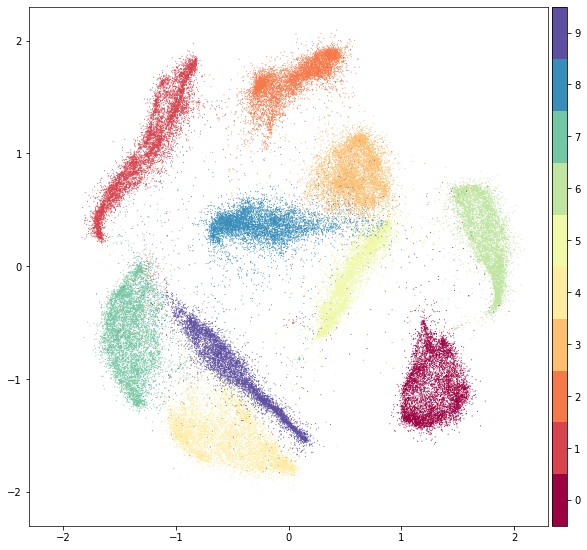

In [8]:
pymde.plot(incremental_mde.X, color_by=mnist.attributes['digits'])

We can compare just the new embedding vectors with the old embedding vectors. Note that both plots are nearly identitcal.

Text(0.5, 1.0, 'Old embedding vectors')

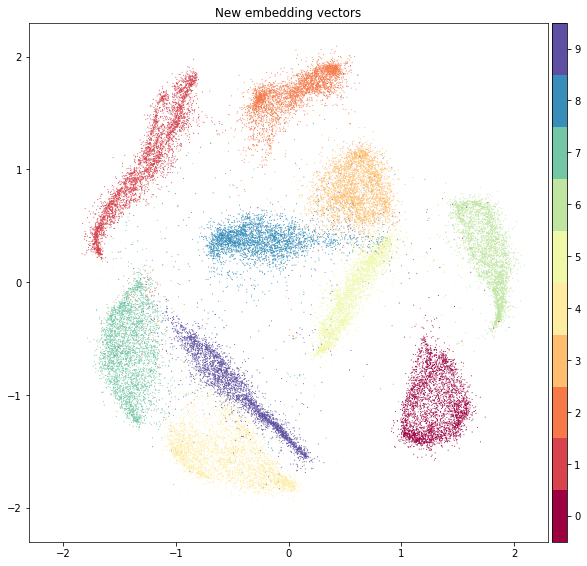

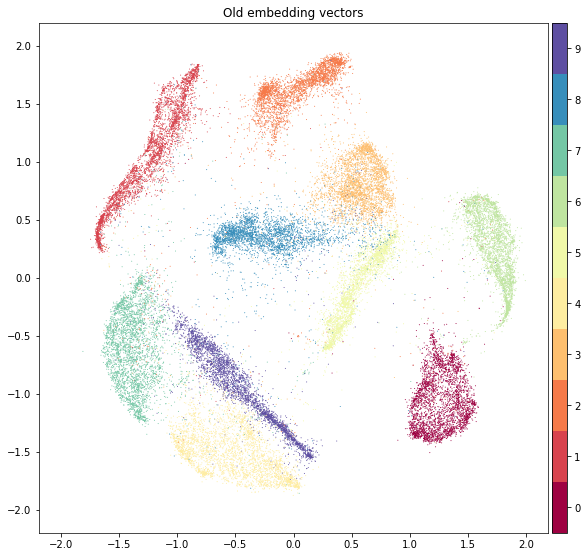

In [9]:
import matplotlib

ax = pymde.plot(incremental_mde.X[n_train:], color_by=mnist.attributes['digits'][n_train:])
ax.set_title('New embedding vectors')

ax = pymde.plot(incremental_mde.X[:n_train], color_by=mnist.attributes['digits'][:n_train])
ax.set_title('Old embedding vectors')